In [1]:
import sys,os
sys.path.append('..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.strategy import StrategyBase, OptParam
import pandas as pd
import numpy as np
import scipy

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [3]:
strategyname = 'strategy_270225'
d, info = matlab.loaddata('../mat/'+strategyname+'.mat')

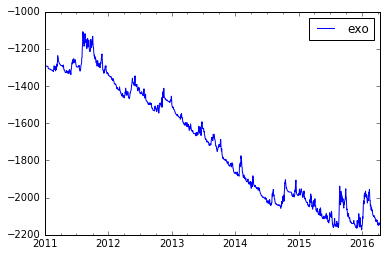

In [4]:
d.plot()


In [5]:
info

{'legs': 4,
 'name': 'BearishCollarBrokenWing',
 'pcf': array([1, 2, 0, 1], dtype=uint8),
 'pcfqty': array([-1, -1,  1,  1], dtype=int16),
 'tickincrement': 0.25,
 'tickvalue': 12.5,
 'underlying': 'EP'}

## Let we have a some champion system in our portfolio

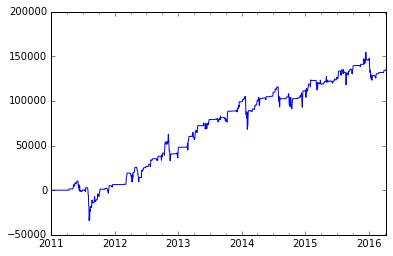

In [58]:
# Position size
# Volatility adjusted
volatility = d_slice.exo.diff().abs().rolling(60).median()
R = 1000.0 / volatility


#Defining entry\exit rules
d_slice=d.ix['2010':]
slow_ma = d_slice.exo.rolling(5).mean()
fast_ma = d_slice.exo.rolling(6).mean()

short_entry = CrossDown(fast_ma, slow_ma)
short_exit = (CrossUp(fast_ma, slow_ma)) 

direction = -1
pl, inposition = backtester.backtest(d_slice, short_entry, short_exit, direction )
equity, stats = backtester.stats(pl, inposition, positionsize=R)

#X axis, initial equity curve
#Colored blue
x=equity
x.plot()

In [59]:
stats

{'avg': 1187.0061104330152,
 'avgbarsintrade': 3.5929203539823007,
 'avgmae': -2995.9130114421532,
 'count': 113,
 'maxdd': -44140.796837386049,
 'netprofit': 134131.69047893072,
 'std': 5075.683193950939,
 'tradesmaxdd': -28202.33529892451,
 'winrate': 0.7345132743362832}

## The question is - does the system risk (drawdown) reflects fair risk of an asset or it underestimates fair risk ?

In [162]:
#Trades count of our champion system
ntrades = stats['count']


#Average bars (days) in position
avgbars = round(stats['avgbarsintrade'])

# n monte-carlo simulations
nmcsimulations = 10000

# Position size for simulation
size = R

# Position direction
direction = -1

# Compare systems params and MC simulation results
system_avgmae = stats['avgmae']
system_tradesmdd = stats['tradesmaxdd'] # We compare closed trades max drawdown


exo_returns = d_slice.exo.diff()

print('Trades to simulate: {0}'.format(ntrades))
print('Holding period to simulate: {0}'.format(avgbars))


Trades to simulate: 113
Holding period to simulate: 4


### How monte-carlo simulation works

Let we have a random swarm (universe) of random picked trades on EXO price, duration of all trades equals average duration of analyzed trading system, trades count too.

* At the first step we should generate 10000 (or more) random simulations, by 100 trades with 4 days holding period in each.

* Next we should calculate stats based on every sample of random trades. We need only MaxDD and MAE (let’s call it in-trade drawdown, more info http://www.mypivots.com/dictionary/definition/409/maximum-adverse-excursion-mae) 

* Finally, we can compare results of particular trading system and distribution of random swarm. And make assumptions about its risks params.


In [142]:
random_pool = np.random.randint(0, len(price)-avgbars,size=(nmcsimulations, ntrades))

In [143]:
trade_results = np.full_like(random_pool, np.nan, dtype=np.float32)
mae_results =  np.full_like(random_pool, np.nan, dtype=np.float32)

# MC Sim results 
mc_mae = np.full(nmcsimulations, np.nan)
mc_mdd = np.full(nmcsimulations, np.nan)

In [144]:

for i,trade_series in enumerate(random_pool):
    
    # calculating equity for each pseudo trade
    for j, price_idx in enumerate(trade_series):
        entry_index = trade_series[j]
        
        if(np.isnan(size.values[entry_index])):
            continue        
        
        px = exo_returns.values[entry_index:entry_index+avgbars] * direction * size.values[entry_index]
        eq = np.cumsum(px)
        # calculate Max Adverse Excursion
        mae_results[i, j] = min(0.0, eq.min())
        trade_results[i, j] = eq[-1]
        
    # Calculate stats for simulation
    trades_equity = pd.Series(trade_results[i])
    
    mdd = (trades_equity - trades_equity.expanding().max()).min()
    avgmae = pd.Series(mae_results[i]).mean()
    
    mc_mae[i] = avgmae
    mc_mdd[i] = mdd

In [145]:
df_mc = pd.DataFrame({'MAE': mc_mae, 'MDD': mc_mdd})

## Comparing results of trading system and Monte-Carlo simulation

Red dotted line is a ‘champion strategy’s’ MAE and DrawDown.

As we can see MAE of the strategy not is so optimistic (that is good, we are not underestimating a risk in single trade). 

MaxDD of strategy lays near median/mean value of entire MC-simulation universe, at least we are not underestimating risks. But we should prepare for higher drawdowns in future, it is better to assume that maximum expected risk of strategy (even all strategies with similar params) will lay in range between -40 000 and -37 000 USD.


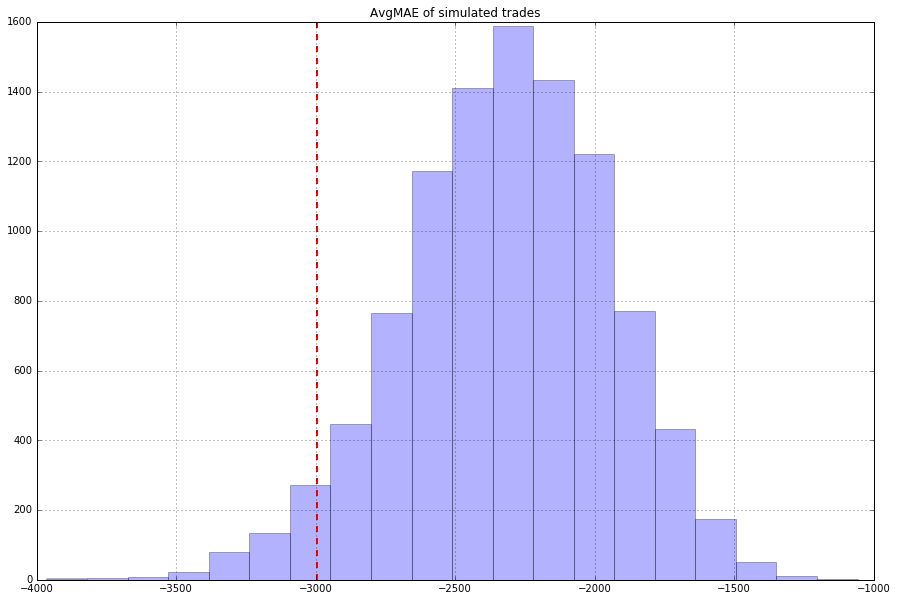

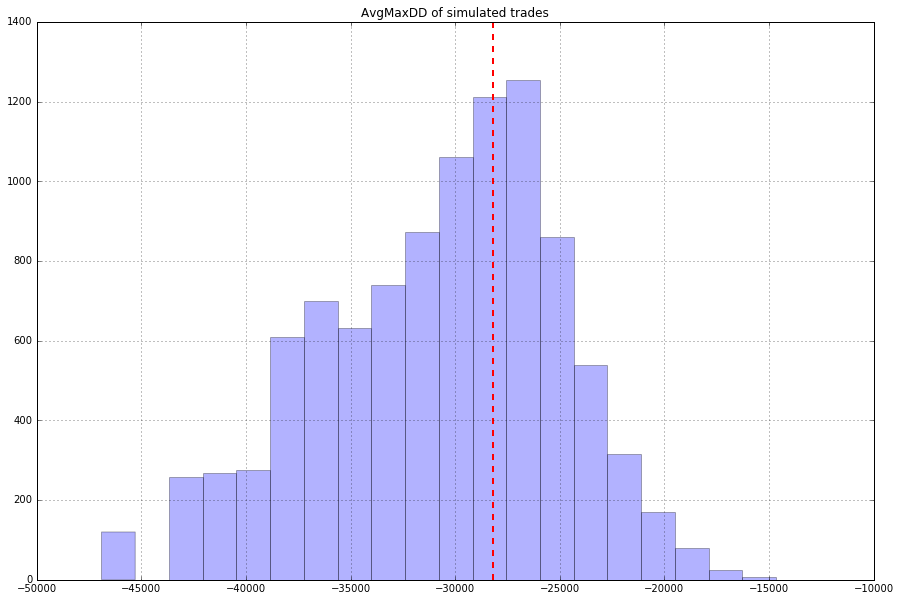

In [168]:
import matplotlib.pyplot as plt
figsize(15,10)

df_mc.MAE.hist(bins=20, alpha=0.3);
plt.axvline(system_avgmae, color='red', linestyle='dashed', linewidth=2)
title('AvgMAE of simulated trades');

figure()
df_mc.MDD.hist(bins=20, alpha=0.3);
plt.axvline(system_tradesmdd, color='red', linestyle='dashed', linewidth=2)
title('AvgMaxDD of simulated trades');
